In [2]:
import json
import random
import os
from datetime import datetime
import numpy as np  # For randomization
import matplotlib.pyplot as plt  # For quick viz

# Create stat_sheets folder
os.makedirs('stat_sheets', exist_ok=True)
print("Setup ready—generating stat sheets!")

Setup ready—generating stat sheets!


In [3]:
def generate_stat_sheet(match_id, player_id):
    """Mock one player's stat sheet after a 'round'."""
    items = ['rubber_duck', 'medkit', 'ammo_box', 'grenade', 'gold_coin']
    looted = {item: random.randint(0, 5) for item in items}  # Random counts
    # Optional: Add locations for heatmaps later
    locations = {item: (random.uniform(0, 100), random.uniform(0, 100)) for item in items if looted[item] > 0}
    
    sheet = {
        "match_id": match_id,
        "player_id": player_id,
        "timestamp": datetime.now().isoformat(),
        "looted_items": looted,
        "locations": locations  # For future heatmaps
    }
    return sheet

# Simulate 50 matches, 4 players each (200 stat sheets total—scale as needed)
stat_sheets = []
for match_num in range(1, 51):
    match_id = f"match_{match_num:03d}"
    for player_num in range(1, 5):
        player_id = f"player_{match_num}_{player_num}"
        sheet = generate_stat_sheet(match_id, player_id)
        stat_sheets.append(sheet)
        # Save as JSON file (mimics client upload)
        file_path = f"stat_sheets/{match_id}_{player_id}.json"
        with open(file_path, 'w') as f:
            json.dump(sheet, f, indent=2)

print(f"Generated {len(stat_sheets)} stat sheets in 'stat_sheets/' folder.")

Generated 200 stat sheets in 'stat_sheets/' folder.


Total Looted: {'rubber_duck': 485, 'medkit': 510, 'ammo_box': 512, 'grenade': 508, 'gold_coin': 496}


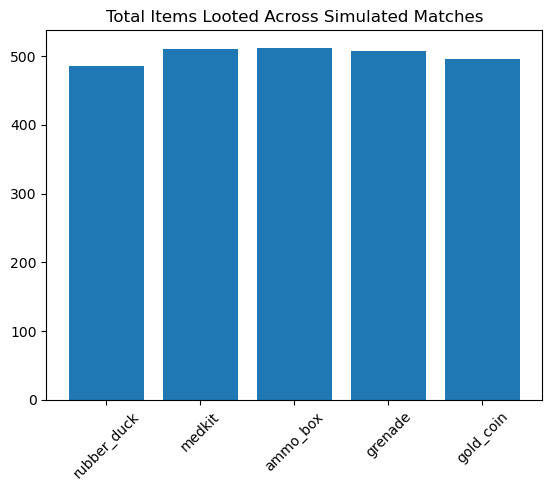

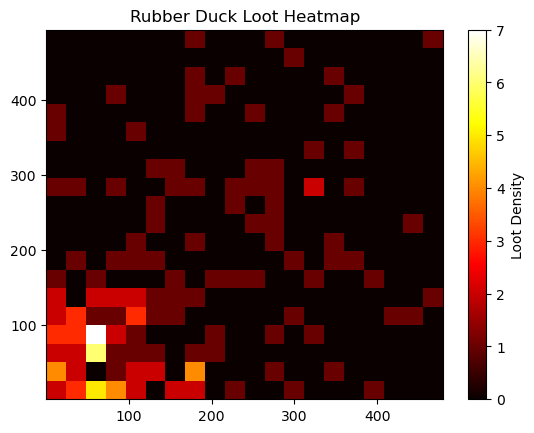

In [4]:
# Aggregate totals (Pandas-style, but simple dict for now)
all_loots = {}
for sheet in stat_sheets:
    for item, count in sheet['looted_items'].items():
        all_loots[item] = all_loots.get(item, 0) + count

print("Total Looted:", all_loots)

# Simple bar chart
items = list(all_loots.keys())
counts = list(all_loots.values())
plt.bar(items, counts)
plt.title('Total Items Looted Across Simulated Matches')
plt.xticks(rotation=45)
plt.savefig('loot_totals.png')  # For your repo README
plt.show()

# Bonus Heatmap (rubber_duck locations)
duck_locs = []
for sheet in stat_sheets:
    if 'rubber_duck' in sheet['locations']:
        x, y = sheet['locations']['rubber_duck']
        duck_locs.extend([x] * sheet['looted_items']['rubber_duck'])  # Multi if count >1
        duck_locs_y = [y] * sheet['looted_items']['rubber_duck']  # Wait, fix: collect pairs

# Proper: Collect all x,y
duck_x = [sheet['locations'].get('rubber_duck', (0,0))[0] * sheet['looted_items'].get('rubber_duck', 0) 
          for sheet in stat_sheets if sheet['looted_items'].get('rubber_duck', 0) > 0]
duck_y = [sheet['locations'].get('rubber_duck', (0,0))[1] * sheet['looted_items'].get('rubber_duck', 0) 
          for sheet in stat_sheets if sheet['looted_items'].get('rubber_duck', 0) > 0]
# Histogram 2D
plt.hist2d(duck_x, duck_y, bins=20, cmap='hot')
plt.title('Rubber Duck Loot Heatmap')
plt.colorbar(label='Loot Density')
plt.savefig('duck_heatmap.png')
plt.show()

In [5]:
# Send data to server API
import requests
import time

# Server configuration
SERVER_URL = "http://localhost:5000"

def send_stat_sheet_to_server(stat_sheet):
    """Send a single stat sheet to the server API"""
    try:
        response = requests.post(f"{SERVER_URL}/api/submit", json=stat_sheet, timeout=5)
        if response.status_code == 201:
            return True, response.json()
        else:
            return False, f"Error {response.status_code}: {response.text}"
    except requests.ConnectionError:
        return False, "Could not connect to server. Make sure server is running!"
    except Exception as e:
        return False, f"Request failed: {str(e)}"

# Test server connection first
print("🌐 Testing server connection...")
try:
    health_response = requests.get(f"{SERVER_URL}/api/health", timeout=5)
    if health_response.status_code == 200:
        print("✅ Server is running and healthy!")
        
        # Send all generated stat sheets to server
        print(f"\n📤 Sending {len(stat_sheets)} stat sheets to server...")
        
        success_count = 0
        failed_count = 0
        
        for i, sheet in enumerate(stat_sheets):
            success, result = send_stat_sheet_to_server(sheet)
            
            if success:
                success_count += 1
                if i % 50 == 0:  # Progress update every 50 sheets
                    print(f"Progress: {i+1}/{len(stat_sheets)} sheets sent...")
            else:
                failed_count += 1
                if failed_count <= 5:  # Show first 5 errors only
                    print(f"❌ Failed to send sheet {i+1}: {result}")
            
            # Small delay to avoid overwhelming the server
            time.sleep(0.01)
        
        print(f"\n📊 Upload Summary:")
        print(f"✅ Successfully sent: {success_count} stat sheets")
        print(f"❌ Failed: {failed_count} stat sheets")
        
        # Get server stats to verify
        stats_response = requests.get(f"{SERVER_URL}/api/aggregate", timeout=5)
        if stats_response.status_code == 200:
            server_stats = stats_response.json()['data']
            print(f"\n🎯 Server now has:")
            print(f"   📋 {server_stats['total_stat_sheets']} total stat sheets")
            print(f"   🎮 {server_stats['total_matches']} unique matches")
            print(f"   👥 {server_stats['total_players']} unique players")
            print(f"   🎁 Total items: {server_stats['total_items']}")
        
    else:
        print("❌ Server health check failed")
        
except requests.ConnectionError:
    print("❌ Could not connect to server!")
    print("💡 To start the server, run in terminal: python server.py")
    print("💡 Then re-run this cell to upload data")
except Exception as e:
    print(f"❌ Error testing server: {e}")

🌐 Testing server connection...
✅ Server is running and healthy!

📤 Sending 200 stat sheets to server...
✅ Server is running and healthy!

📤 Sending 200 stat sheets to server...
Progress: 1/200 sheets sent...
Progress: 1/200 sheets sent...
Progress: 51/200 sheets sent...
Progress: 51/200 sheets sent...
Progress: 101/200 sheets sent...
Progress: 101/200 sheets sent...
Progress: 151/200 sheets sent...
Progress: 151/200 sheets sent...

📊 Upload Summary:
✅ Successfully sent: 200 stat sheets
❌ Failed: 0 stat sheets

📊 Upload Summary:
✅ Successfully sent: 200 stat sheets
❌ Failed: 0 stat sheets

🎯 Server now has:
   📋 201 total stat sheets
   🎮 51 unique matches
   👥 201 unique players
   🎁 Total items: {'ammo_box': 512, 'gold_coin': 498, 'grenade': 508, 'medkit': 510, 'rubber_duck': 490}

🎯 Server now has:
   📋 201 total stat sheets
   🎮 51 unique matches
   👥 201 unique players
   🎁 Total items: {'ammo_box': 512, 'gold_coin': 498, 'grenade': 508, 'medkit': 510, 'rubber_duck': 490}


📊 Fetching data from server for visualization...
🎁 Server Data vs Local Data Comparison:
Local total items: {'rubber_duck': 485, 'medkit': 510, 'ammo_box': 512, 'grenade': 508, 'gold_coin': 496}
Server total items: {'ammo_box': 512, 'gold_coin': 498, 'grenade': 508, 'medkit': 510, 'rubber_duck': 490}
🎁 Server Data vs Local Data Comparison:
Local total items: {'rubber_duck': 485, 'medkit': 510, 'ammo_box': 512, 'grenade': 508, 'gold_coin': 496}
Server total items: {'ammo_box': 512, 'gold_coin': 498, 'grenade': 508, 'medkit': 510, 'rubber_duck': 490}


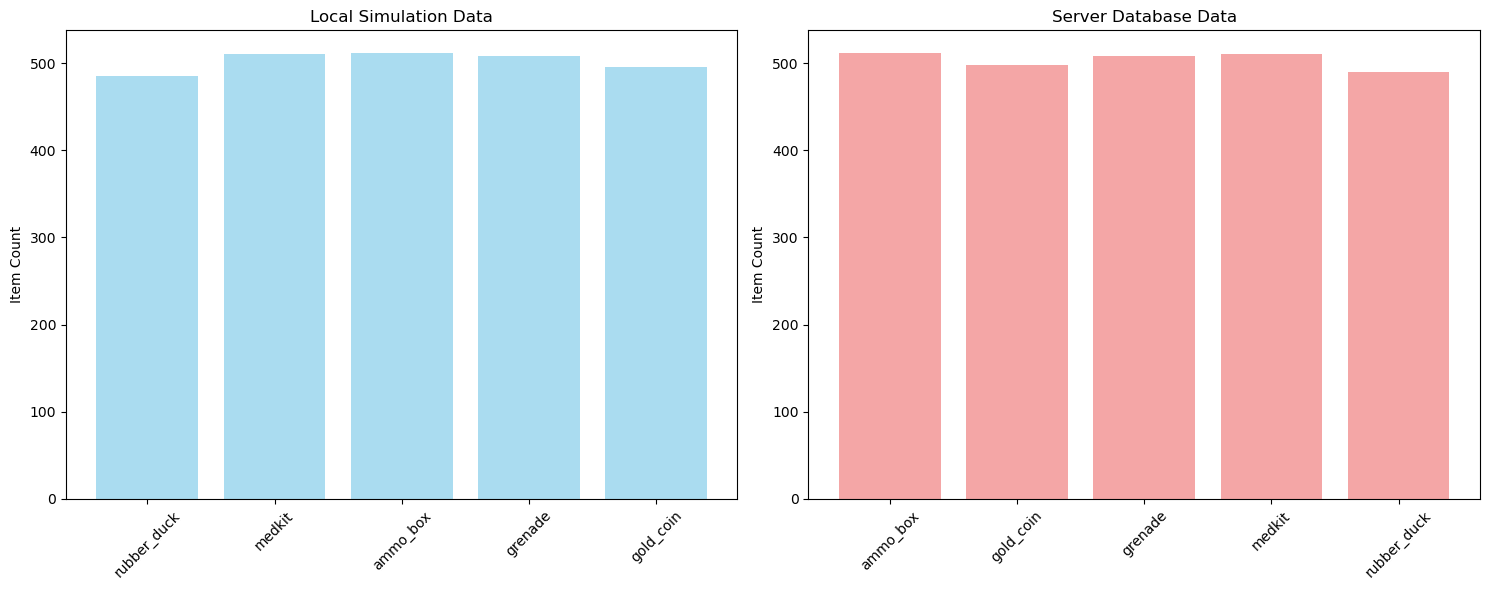


🦆 Rubber Duck Heatmap from Server (490 data points):


C:\Users\david\AppData\Local\Temp\ipykernel_18372\1898399066.py:58: UserWarning: Glyph 129414 (\N{DUCK}) missing from font(s) DejaVu Sans.
  plt.savefig('server_duck_heatmap.png', dpi=150, bbox_inches='tight')
c:\Users\david\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129414 (\N{DUCK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\david\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129414 (\N{DUCK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


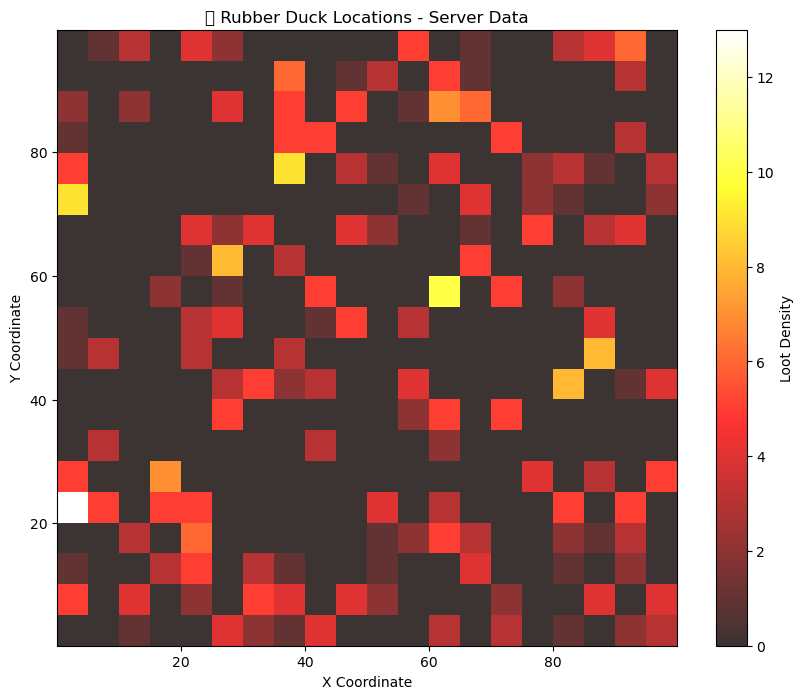


✅ Successfully retrieved and visualized server data!
📈 Charts saved: local_vs_server_comparison.png, server_duck_heatmap.png

🎯 Summary of what you can do:
1. Run 'python server.py' in terminal to start the API server
2. Execute cell 4 to upload all simulated data to server
3. Execute cell 5 to visualize server data
4. Visit http://localhost:5000 to see the API documentation
5. Use http://localhost:5000/api/stats to view all data
6. Use http://localhost:5000/api/aggregate to see summary stats


In [6]:
# Retrieve and visualize data from server
print("📊 Fetching data from server for visualization...")

try:
    # Get aggregate stats from server
    response = requests.get(f"{SERVER_URL}/api/aggregate", timeout=5)
    if response.status_code == 200:
        server_data = response.json()['data']
        server_loots = server_data['total_items']
        
        print("🎁 Server Data vs Local Data Comparison:")
        print(f"Local total items: {all_loots}")
        print(f"Server total items: {server_loots}")
        
        # Create comparison visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Local data chart
        local_items = list(all_loots.keys())
        local_counts = list(all_loots.values())
        ax1.bar(local_items, local_counts, color='skyblue', alpha=0.7)
        ax1.set_title('Local Simulation Data')
        ax1.set_ylabel('Item Count')
        ax1.tick_params(axis='x', rotation=45)
        
        # Server data chart
        server_items = list(server_loots.keys())
        server_counts = list(server_loots.values())
        ax2.bar(server_items, server_counts, color='lightcoral', alpha=0.7)
        ax2.set_title('Server Database Data')
        ax2.set_ylabel('Item Count')
        ax2.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.savefig('local_vs_server_comparison.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        # Get heatmap data for rubber ducks from server
        heatmap_response = requests.get(f"{SERVER_URL}/api/heatmap/rubber_duck", timeout=5)
        if heatmap_response.status_code == 200:
            heatmap_data = heatmap_response.json()['data']
            server_locations = heatmap_data['locations']
            
            if server_locations:
                print(f"\n🦆 Rubber Duck Heatmap from Server ({len(server_locations)} data points):")
                
                # Extract x, y coordinates
                server_x = [loc[0] for loc in server_locations]
                server_y = [loc[1] for loc in server_locations]
                
                # Create server heatmap
                plt.figure(figsize=(10, 8))
                plt.hist2d(server_x, server_y, bins=20, cmap='hot', alpha=0.8)
                plt.title('🦆 Rubber Duck Locations - Server Data')
                plt.xlabel('X Coordinate')
                plt.ylabel('Y Coordinate')
                plt.colorbar(label='Loot Density')
                plt.savefig('server_duck_heatmap.png', dpi=150, bbox_inches='tight')
                plt.show()
            else:
                print("No rubber duck location data found on server")
        
        print(f"\n✅ Successfully retrieved and visualized server data!")
        print(f"📈 Charts saved: local_vs_server_comparison.png, server_duck_heatmap.png")
        
    else:
        print(f"❌ Failed to get server data: {response.status_code}")
        
except requests.ConnectionError:
    print("❌ Could not connect to server to retrieve data")
except Exception as e:
    print(f"❌ Error retrieving server data: {e}")

print("\n🎯 Summary of what you can do:")
print("1. Run 'python server.py' in terminal to start the API server")
print("2. Execute cell 4 to upload all simulated data to server")
print("3. Execute cell 5 to visualize server data")
print("4. Visit http://localhost:5000 to see the API documentation")
print("5. Use http://localhost:5000/api/stats to view all data")
print("6. Use http://localhost:5000/api/aggregate to see summary stats")